# 第8章 ベイズ推定：データを元に「確信」を高める手法(自習書き込み用)

## 「08-bayes_normal.py」の解説

ITエンジニアための機械学習理論入門「第8章 ベイズ推定:データを元に「確信」を高める手法」で使用しているサンプルコード「08-bayes_normal.py」の解説です。

※ 解説用にコードの内容は少し変更しています。

はじめに必要なモジュールをインポートしておきます。

関数 normal は、正規分布に従う乱数を生成するために利用します。関数 norm は、正規分布の確率密度関数（PDF）を提供します。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import normal
from scipy.stats import norm

import matplotlib
matplotlib.rcParams['font.size'] = 12

平均2、標準偏差1の正規分布から100個のサンプルを取得します。

※ ここで定義した mu_true, beta_true は、他の関数からグローバル変数として参照されます。

In [2]:
#求めたいμとβ(本書で印なしのμとβ)
mu_true = 2.0
beta_true = 1.0
#locは平均、scaleは標準偏差
#ds = normal(loc=mu_true, scale=1.0/beta_true, size=100)
#実は、以下が正しいのではないか？
ds = normal(loc=mu_true, scale=np.sqrt(1.0/beta_true), size=100)

平均 μ の事前分布として平均2.0、標準偏差1.0の正規分布を用いて、ベイズ推定による事後分布をグラフ表示する関数を用意します。

In [3]:
#トレーニングセットの平均値μと、分散βはわかっているのだけど、
#あえて、βだけわかっている状況でμを推定しようというもの
#トレーニングセット(真の分布の一部のデータ)は標本に過ぎないので、標本分散から標本期待値（平均値）を単純に求めても
#真の分布のそれにならないはず。それをベイズ推定で推定しようというもの。
def estimate_mu(subplot, trainset):
    # 事前分布
    mu_0 = -2.0
    beta_0 = 1.0

    # 事後分布
    n = len(trainset)
    mu_ML = np.mean(trainset)
    mu_N = (beta_true*mu_ML + beta_0*mu_0/n)/(beta_true+beta_0/n) #式(8.43)を計算(ただし、1/nを分子と分母に掛けている)
    beta_N = beta_0 + n*beta_true #式(8.36)。これの逆数が分散になる。

    # 平均μの推定結果を表示
    # まずはグラフのタイトルとx軸を用意
    subplot.set_title("N=%d" % n)
    linex = np.arange(-10, 10.1, 0.01) #x軸を生成
    #→numpy.arange(start, stop, step)
    #start ≦ n < stopで間隔はstep

    # 平均μの確率分布
    sigma = 1.0/beta_N #式(8.36)の逆数→分散
    mu_est = norm(loc=mu_N, scale=np.sqrt(sigma)) #平均と分散をnorm関数に入れて、データを得る。
    label = "mu_N=%.2f\nvar=%.2f" % (mu_N, sigma)
    print("======================")
    print("PRINT MU_EST")
    print(mu_est)
    print("PRINT PDF")
    print(mu_est.pdf)
    print("PRINT PDF2")
    print(mu_est.pdf(linex))
    print("======================")
    #mu_estは正規分布の関数を返すらしい。mu_est.pdfを実行すると、その確率密度関数の各値(xに対するy→確率値)を返す。
    #それを、プロットしていく
    subplot.plot(linex, mu_est.pdf(linex), color='red', label=label)
    subplot.legend(loc=2)

    # トレーニングセットを表示
    #トレーニングセットの分布(ｘ軸)を示したいだけなので確率値(y)は適当らしい(0.2を設定)
    subplot.scatter(trainset, [0.2]*n, marker='o', color='blue')
    subplot.set_xlim(-5,5)
    subplot.set_ylim(0)

事前に生成した100個のデータから、先頭の2, 4, 10, 100個分を用いて推定した結果をそれぞれグラフに表示します。

PRINT MU_EST
PRINT PDF
<bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3c6111b80>>
PRINT PDF2
[9.48823417e-85 1.33335672e-84 1.87316927e-84 ... 1.82077187e-50
 1.40128923e-50 1.07812657e-50]
PRINT MU_EST
PRINT PDF
<bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3c595e2b0>>
PRINT PDF2
[1.78936607e-143 3.17346735e-143 5.62537819e-143 ... 3.48547328e-081
 2.26611571e-081 1.47260157e-081]
PRINT MU_EST
PRINT PDF
<bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3c5917730>>
PRINT PDF2
[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.49203352e-156
 6.13104513e-157 2.51659148e-157]
PRINT MU_EST
PRINT PDF
<bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe3c58e84f0>>
PRINT PDF2
[0. 0. 0. ... 0. 0. 0.]


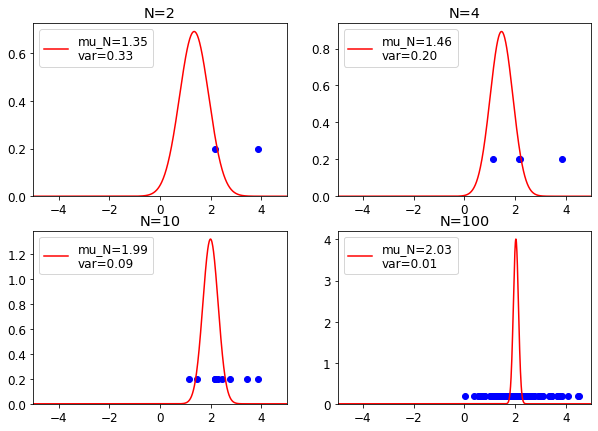

In [4]:
fig = plt.figure(figsize=(10, 7))
for i, n in enumerate([2, 4, 10, 100]):
    subplot = fig.add_subplot(2, 2, i+1)
    estimate_mu(subplot, ds[:n])

使用するデータが多くなるほど、事後分布の最大値部分が真の母数2に近づくと共に、事後分布の分散が小さくなることがわかります。

ベイズ推定で得られた事後分布を用いて、次に得られるデータの予想分布をグラフ表示する関数を用意します。

In [5]:
#確率密度関数を予測しようとするもの。今度はトレーニングセット(x軸)に対する確率(y)の値を予測していく。
def estimate_pdf(subplot, trainset):
    # 事前分布
    mu_0 = -2.0
    beta_0 = 1.0

    # 事後分布 μNは上に出てきたものと同じ。
    n = len(trainset)
    mu_ML = np.mean(trainset)
    mu_N = (beta_true*mu_ML + beta_0*mu_0/n)/(beta_true+beta_0/n)
    beta_N = beta_0 + n*beta_true
    
    # 次に得られるデータの推定分布を表示
    subplot.set_title("N=%d" % n)
    linex = np.arange(-10,10.1,0.01)

    # 真の分布を表示
    orig = norm(loc=mu_true, scale=np.sqrt(1.0/beta_true))
    subplot.plot(linex, orig.pdf(linex), color='green', linestyle='--')

    # 推定分布を表示
    sigma = 1.0/beta_true+1.0/beta_N
    mu_est = norm(loc=mu_N, scale=np.sqrt(sigma))
    label = "mu_N=%.2f\nvar=%.2f" % (mu_N, sigma)
    subplot.plot(linex, mu_est.pdf(linex), color='red', label=label)
    subplot.legend(loc=2)

    # トレーニングセットを表示
    subplot.scatter(trainset, orig.pdf(trainset), marker='o', color='blue')
    subplot.set_xlim(-5,5)
    subplot.set_ylim(0)

先ほどと同様に、推定に使用するデータ数を変化させながら、結果をグラフ表示していきます。

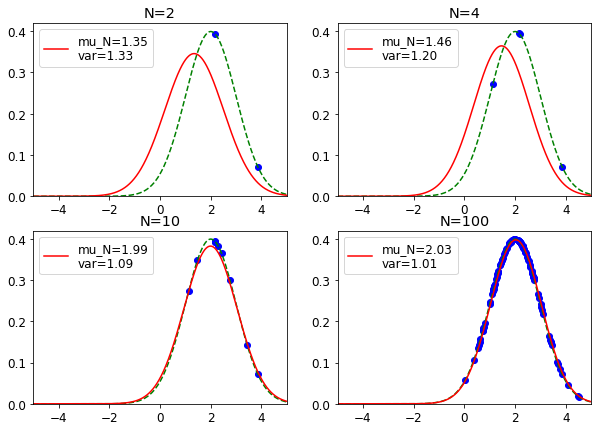

In [6]:
fig = plt.figure(figsize=(10, 7))
for i, n in enumerate([2, 4, 10, 100]):
    subplot = fig.add_subplot(2, 2, i+1)
    estimate_pdf(subplot, ds[:n])

データ数が増えるほど、真の分布に予測が近づくことがわかります。